# Дообучение больших языковых моделей. Квантизация и адаптеры.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://huggingface.co/docs/transformers/en/quantization/bitsandbytes
* https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0
* https://huggingface.co/datasets/openai/gsm8k
* https://huggingface.co/docs/peft/main/en/quicktour
* https://discuss.pytorch.org/t/pytorch-model-size-in-mbs/149002/3
* https://huggingface.co/docs/peft/package_reference/peft_model#peft.PeftMixedModel.print_trainable_parameters
* https://huggingface.co/docs/peft/package_reference/peft_model#peft.PeftMixedModel.merge_and_unload

In [ ]:
!pip install bitsandbytes datasets peft
!pip install --quiet --upgrade transformers
!pip install -U datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

## Задачи для совместного разбора

1\. Обсудите понятие квантизации в контексте обучения моделей и рассмотрите примеры с использованием `bitsandbytes`

In [ ]:
from transformers import AutoModelForCausalLM

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

model = AutoModelForCausalLM.from_pretrained(
    model_name
)

In [ ]:
model

In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model_4bit = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quantization_config
)

In [ ]:
model_4bit

2\. Обсудите концепцию адаптеров и способы дообучения LLM с использованием адаптеров при помощи пакета peft

In [ ]:
from peft import LoraConfig, TaskType, get_peft_model

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1
)

peft_model = get_peft_model(model_4bit, peft_config)

In [ ]:
peft_model

PeftModel(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear4bit(in_feat

In [ ]:
peft_model.print_trainable_parameters()

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023


In [ ]:
# training ...

In [ ]:
peft_model = peft_model.eval()
peft_model

PeftModel(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear4bit(in_feat

In [ ]:
tuned_model = peft_model.merge_and_unload().eval()
tuned_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear4bit(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), e

## Задачи для самостоятельного решения

### 1.

<p class="task" id="1"></p>

1\. Создайте модель `TinyLLama/TinyLlama-1.1B-Chat-v1` без квантизации. Посчитайте и выведите на экран объем памяти в мегабайтах, необходимый для хранения весов модели. Создайте квантизированную версию этой модели при помощи `bitsandbytes`. Выясните, насколько модель стала компактнее относительно оригинальной версии. Опишите, что изменилось в структуре модели.


- [x] Проверено на семинаре

In [ ]:
from transformers import AutoModelForCausalLM

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

model = AutoModelForCausalLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): 

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
total_params

1100048384

In [ ]:
next(model.parameters()).dtype

torch.float32

In [ ]:
tp_bytes = total_params * 4 # float32 = 4 bytes
print(tp_bytes, 'bytes')

4400193536 bytes


In [ ]:
orig_model_size = tp_bytes / (1024 ** 2)  # 1024 ** 2 - кол-во байт в 1 МВ
print(orig_model_size, 'MB')

4196.3515625 MB


In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model_4bit = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quantization_config
)

In [ ]:
model_4bit

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear4bit(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), e

In [ ]:
total_params = sum(p.numel() for p in model_4bit.parameters())
total_params

615606272

In [ ]:
next(model_4bit.parameters()).dtype

torch.float16

In [ ]:
tp_bytes = total_params * 0.5 # float4 = 0.5 bytes
print(tp_bytes, 'bytes')

307803136.0 bytes


In [ ]:
model_4bit_size = tp_bytes / (1024 ** 2)  # 1024 ** 2 - кол-во байт в 1 МВ
print(model_4bit_size, 'MB')

293.5439453125 MB


In [ ]:
orig_model_size/model_4bit_size

14.29547987451304

In [ ]:
print((orig_model_size - model_4bit_size)/orig_model_size*100, '%')

93.00478186966728 %


In [ ]:
orig_model_size, model_4bit_size

(4196.3515625, 293.5439453125)

In [ ]:
4196.3515625 - 293.5439453125

3902.8076171875

In [ ]:
3902.8076171875 / 4196.3515625

0.9300478186966729

In [ ]:
print(0.9300478186966729 * 100, '%')

93.00478186966728 %


 квантованная модель стала занимать на 93% меньше памяти, чем оригинальная версия (только ~7% от размера оригинальной модели)

In [ ]:
round(4196.3515625 * 0.07) == round(model_4bit_size)

True

если размер уменьшился в N раз, то он уменьшился на (1 - 1/N) * 100%

1 - 1/14.3 ≈ 0.93 (т.е. 93%)

### 2.

<p class="task" id="2"></p>

2\. Создайте набор данных при помощи любой современной языковой модели. Датасет должен быть содержать примеры задач на линейный поиск в небольшом массиве чисел. Размер датасета выберите сами, рекомендуемый размер - несколько сотен примеров.

Пример может выглядеть следующим образом:

```
{
        "question": "Find the number 5 in the array [1, 2, 3, 4, 5]",
        "answer": "Step 1: Check the first number (1). No. Step 2: Check the second number (2). No. Step 3: Check the third number (3). No. Step 4: Check the fourth number (4). No. Step 5: Check the fifth number (5). Yes. Answer: index 4."
}
```

В качестве решения приведите используемый промпт.

Сохраните примеры в формате JSON на диск.  При помощи пакета datasets загрузите датасет с диска. Выведите на экран один пример из датасета

- [ ] Проверено на семинаре

Используемый промпт:
```
Сгенерируй от 300 до 500 задач по линейному поиску в массиве целых чисел. Каждый пример должен быть в формате JSON с двумя ключами: "question" и "answer". В "answer" обязательно должна прописываться инструкция как в примере. Запиши все в  .txt или .json и дай мне скачать.

Пример:
{
  "question": "Find the number 5 in the array [1, 2, 3, 4, 5]",
  "answer": "Step 1: Check the first number (1). No. Step 2: Check the second number (2). No. Step 3: Check the third number (3). No. Step 4: Check the fourth number (4). No. Step 5: Check the fifth number (5). Yes. Answer: index 4."
}

```


In [ ]:
from datasets import Dataset

dataset = Dataset.from_json('linear_search_tasks.txt')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset[1]

{'question': 'Find the number 15 in the array [82, 7, 15, 56, 42, 33, 80, 91, 14, 12, 59, 32]',
 'answer': 'Step 1: Check the 1st number (82). No. Step 2: Check the 2nd number (7). No. Step 3: Check the 3rd number (15). Yes. Answer: index 2.'}

### 3.

<p class="task" id="3"></p>

3\. Преобразуйте датасет следующим образом:

Каждую пару вопрос-ответ объедините в строку по следующему шаблону:

```
### Instruction:\n<ВОПРОС>\n### Response:\n<ОТВЕТ>
```

При помощи токенизатора, соответствующего модели, закодируйте эти строки. Продублируйте значения поля input_ids в виде поля `labels`. Итого каждый пример датасета должен представлять собой словарь с ключами 'input_ids', 'attention_mask', 'labels'. Выведите один пример на экран.


- [ ] Проверено на семинаре

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [ ]:
def format_example(example):
  prompt = f"### Instruction:\n{example['question']}\n### Response:\n{example['answer']}"
  tokenized = tokenizer(prompt, truncation=True, padding='max_length', max_length=256)

  return {'input_ids': tokenized['input_ids'],
          'attention_mask': tokenized['attention_mask'],
          'labels': tokenized['input_ids']}

In [ ]:
tokenized_dataset = dataset.map(format_example)

Map:   0%|          | 0/454 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset[0]

{'question': 'Find the number 5 in the array [86, 6, 83, 2, 5, 74, 96, 40, 95, 9]',
 'answer': 'Step 1: Check the 1st number (86). No. Step 2: Check the 2nd number (6). No. Step 3: Check the 3rd number (83). No. Step 4: Check the 4th number (2). No. Step 5: Check the 5th number (5). Yes. Answer: index 4.',
 'input_ids': [1,
  835,
  2799,
  4080,
  29901,
  13,
  12542,
  278,
  1353,
  29871,
  29945,
  297,
  278,
  1409,
  518,
  29947,
  29953,
  29892,
  29871,
  29953,
  29892,
  29871,
  29947,
  29941,
  29892,
  29871,
  29906,
  29892,
  29871,
  29945,
  29892,
  29871,
  29955,
  29946,
  29892,
  29871,
  29929,
  29953,
  29892,
  29871,
  29946,
  29900,
  29892,
  29871,
  29929,
  29945,
  29892,
  29871,
  29929,
  29962,
  13,
  2277,
  29937,
  13291,
  29901,
  13,
  14448,
  29871,
  29896,
  29901,
  5399,
  278,
  29871,
  29896,
  303,
  1353,
  313,
  29947,
  29953,
  467,
  1939,
  29889,
  16696,
  29871,
  29906,
  29901,
  5399,
  278,
  29871,
  29906,
 

### 4.

<p class="task" id="4"></p>

4\. Обучите модель на данном датасете, используя адаптеры LoRA из пакета `peft`.

Создайте `PeftModelForCausalLM` с адаптерами для слоев `q_proj` и `v_proj`. Остальные гиперпараметры выберите самостоятельно.Выведите на экран структуру модели и долю обучаемых параметров.

Визуализируйте кривые обучения. Сохраните обученную модель на диск.

- [ ] Проверено на семинаре

In [ ]:
from peft import LoraConfig, TaskType, get_peft_model

peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05
)

peft_model = get_peft_model(model_4bit, peft_config)

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
peft_model.print_trainable_parameters()

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023


In [ ]:
peft_model

PeftModel(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear4bit(in_fea

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
  output_dir="./output",
  per_device_train_batch_size=4,
  gradient_accumulation_steps=4,
  learning_rate=3e-4,
  num_train_epochs=3,
  logging_steps=10,
  save_strategy="epoch",
  report_to="none",
  fp16=True
)

In [ ]:
trainer = Trainer(
  model = peft_model,
  args=training_args,
  train_dataset = tokenized_dataset
)

trainer.train()

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:463: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Step,Training Loss
10,4.283700
20,0.608100
30,0.292200
40,0.230300
50,0.204200
60,0.190300
70,0.201100
80,0.192900


TrainOutput(global_step=87, training_loss=0.7282367012966638, metrics={'train_runtime': 154.9512, 'train_samples_per_second': 8.79, 'train_steps_per_second': 0.561, 'total_flos': 2166589476569088.0, 'train_loss': 0.7282367012966638, 'epoch': 3.0})

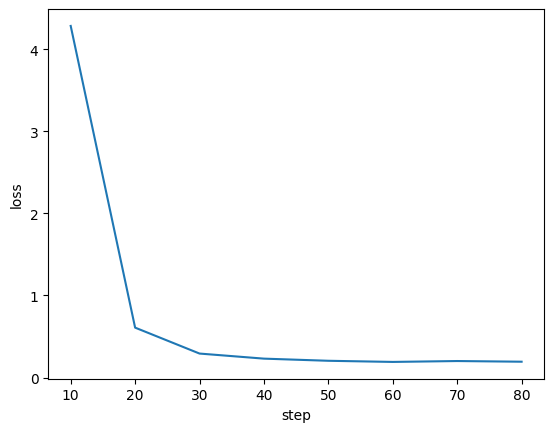

In [ ]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

loss = [x['loss'] for x in history if 'loss' in x]
step = [x['step'] for x in history if 'loss' in x]

plt.plot(step, loss)
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

In [ ]:
saved_model_path = "./tinyllama_lora"
peft_model.save_pretrained(saved_model_path)

### 5.

<p class="task" id="5"></p>

5\. Используя дообученную модель, получите прогнозы для тестового множества. Проанализируйте качество полученных прогнозов любым адекватным образом. Сделайте выводы.

- [ ] Проверено на семинаре

In [ ]:
from transformers import pipeline
from peft import PeftModelForCausalLM
import torch as th

model = PeftModelForCausalLM.from_pretrained(
  model_4bit,
  saved_model_path
)

generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer
)

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
Device set to use cuda:0


Используемый промпт:
```
Сгенерируй для тестового множества от 100 до 200 задач по линейному поиску в массиве целых чисел. Они должны отличаться от прошлой генерации. Каждый пример должен быть в формате JSON с двумя ключами: "question" и "answer". В "answer" обязательно должна прописываться инструкция как в примере. Запиши все в  .txt или .json и дай мне скачать.

Пример:
{
  "question": "Find the number 5 in the array [1, 2, 3, 4, 5]",
  "answer": "Step 1: Check the first number (1). No. Step 2: Check the second number (2). No. Step 3: Check the third number (3). No. Step 4: Check the fourth number (4). No. Step 5: Check the fifth number (5). Yes. Answer: index 4."
}



```


In [ ]:
from datasets import Dataset

test_dataset = Dataset.from_json('linear_search_test.json')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
test_dataset[0]

{'question': 'Find the number 15 in the array [0, 10, 0, 15, 15, 4]',
 'answer': 'Step 1: Check the first number (0). No. Step 2: Check the second number (10). No. Step 3: Check the third number (0). No. Step 4: Check the 4th number (15). Yes. Answer: index 3.'}

In [ ]:
test_questions = [test_dataset[i] for i in range(6)]

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

results = []
for item in test_questions:
  prompt = f"### Instruction:\n{item['question']}\n### Response:\n"
  output = generator(prompt)
  generated = output[0]['generated_text'].split()"### Response:"[1].strip()
  results.append({
        "question": item["question"],
        "expected": item["answer"],
        "generated": generated
    })

for res in results:
  reference = [res['expected'].split()]
  candidate = res['generated'].split()
  bleu = sentence_bleu(reference, candidate, weights=(0.5, 0.5))
  res['bleu'] = bleu

for i, res in enumerate(results):
  print(f"\nQ {i+1}: {res['question']}")
  print(f"Expected: {res['expected']}")
  print(f"Predicted: {res['generated']}")
  print(f"BLEU: {res['bleu']:.2f}")


Q 1: Find the number 15 in the array [0, 10, 0, 15, 15, 4]
Expected: Step 1: Check the first number (0). No. Step 2: Check the second number (10). No. Step 3: Check the third number (0). No. Step 4: Check the 4th number (15). Yes. Answer: index 3.
Predicted: Step 1: Check the 1st number (0). No. Step 2: Check the 2nd number (10). No. Step 3: Check the 3rd number (0). No. Step 4: Check the 4th number (15). Yes. Answer: index 3.
BLEU: 0.87

Q 2: Find the number 14 in the array [1, 6, 5, 11, 6, 5, 12, 14, 14, 4, 4, 9, 6]
Expected: Step 1: Check the first number (1). No. Step 2: Check the second number (6). No. Step 3: Check the third number (5). No. Step 4: Check the 4th number (11). No. Step 5: Check the 5th number (6). No. Step 6: Check the 6th number (5). No. Step 7: Check the 7th number (12). No. Step 8: Check the 8th number (14). Yes. Answer: index 7.
Predicted: Step 1: Check the 1st number (1). No. Step 2: Check the 2nd number (6). No. Step 3: Check the 3rd number (5). No. Step 4: 